# Input Driven Observations ("GLM-HMM")

Notebook adapted from Zoe Ashwood

This notebook demonstrates the "InputDrivenObservations" class, and illustrates its use in the context of modeling decision-making data as in Ashwood et al. (2020) ([Mice alternate between discrete strategies during perceptual
decision-making](https://www.biorxiv.org/content/10.1101/2020.10.19.346353v1.full.pdf)).

Compared to the model considered in the notebook ["2 Input Driven HMM"](https://github.com/lindermanlab/ssm/blob/master/notebooks/2%20Input%20Driven%20HMM.ipynb), Ashwood et al. (2020) assumes a stationary transition matrix where transition probabilities *do not* depend on external inputs. However, observation probabilities now *do* depend on external covariates according to:


for $c \neq C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

and for $c = C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{1}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

where $c \in \{1, ..., C\}$ indicates the categorical class for the observation, $u_{t} \in \mathbb{R}^{M}$ is the set of input covariates, and $w_{kc} \in \mathbb{R}^{M}$ is the set of input weights associated with state $k$ and class $c$. These weights, along with the transition matrix and initial state probabilities, will be learned.

In Ashwood et al. (2020), $C = 2$ as $y_{t}$ represents the binary choice made by an animal during a 2AFC (2-Alternative Forced Choice) task. The above equations then reduce to:

$$
\begin{align}
\Pr(y_t = 0 \mid z_{t} = k, u_t, w_{k}) = 
\frac{\exp\{w_{k}^\mathsf{T} u_t\}}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}} = \frac{1}
{1 + \exp\{-w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

$$
\begin{align}
\Pr(y_t = 1 \mid z_{t} = k, u_t, w_{k}) = 
\frac{1}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

and only a single weight vector, $w_{k}$, is associated with each state.

## 1. Setup
First, you must clone the `ssm` repository and install all of the dependencies. The `ssm` package we are using can be found, along with installation instructions, [here](https://github.com/lindermanlab/ssm.git). 

The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [1]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from sglm import hmmUtils, utils
import ssm

npr.seed(42)

#### 1a. Below, we will be importing the data and filtering based on any feature you would like.

In [2]:
data_ = pd.read_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FullMerged_2nBack_100423.csv')

In [3]:
# Filter the DataFrame to select all trials with 'Session' containing 'GR'

#animal = 'GR'
#filtered_data = data_[(data_['Session ID'].str.contains(animal)) & (data_['Condition'] == '80-20')]
filtered_data = data_[(data_['Condition'] == '80-20')]

# Extracting specific columns
data_x = filtered_data[['1_Port', '2_Port', '1_Reward', '2_Reward']]
data_y = filtered_data['Reward']
data_sessions = len(data_x)
num_sess = len(filtered_data['Session ID'].unique())
num_trials_per_sess = data_sessions

## 2. Input Driven Observations
We create a HMM with input-driven observations and 'standard' (stationary) transitions with the following line:  
```python
        ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", observation_kwargs=dict(C=num_categories), transitions="standard")
```

As in Ashwood et al. (2020), we are going to model an animal's binary choice data during a decision-making task, so we will set `num_categories=2` because the animal only has two options available to it. We will also set `obs_dim = 1` because the dimensionality of the observation data is 1 (if we were also modeling, for example, the binned reaction time of the animal, we could set `obs_dim = 2`).  For the sake of simplicity, we will assume that an animal's choice in a particular state is only affected by the external stimulus associated with that particular trial, and its innate choice bias. Thus, we will set `input_dim = 2` and we will simulate input data that resembles sequences of stimuli in what follows.  In Ashwood et al. (2020), they found that many mice used 3 decision-making states when performing 2AFC tasks. We will, thus, set `num_states = 3`.

### 2a. Create external input sequences

Simulate an example set of external inputs for each trial in a session. We will create an array of size `(num_sess x num_trials_per_sess x num_covariates)`. As in Ashwood et al. (2020), for each trial in a session we will include the stimulus presented to the animal at that trial, as well as a '1' as the second covariate (so as to capture the animal's innate bias for one of the two options available to it). We will simulate stimuli sequences so as to resemble the sequences of stimuli in the International Brain Laboratory et al. (2020) task.

In [25]:
# number of latent states, adds bias 
K = 3 
# C represents the binary choice the animal must make 
C = 2 
# number of GLM inputs (regressors) 
D = data_x.shape[1] 

num_sess = 10 # number of example sessions
num_trials_per_sess = data_sessions # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, K)) # initialize inpts array
stim_vals = [0, 1]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct formats

## 3. Fit GLM-HMM and perform recovery analysis

### 3a. Maximum Likelihood Estimation

Now we instantiate a new GLM-HMM and check that we can recover the generative parameters in simulated data:

In [26]:
# Data inputs 
choices = filtered_data['Decision'].to_numpy()
choices = choices.reshape(-1, 1)
choices = choices.astype(int)

inpts = filtered_data[['1_Port', '1_Reward', '2_Port', '2_Reward']].to_numpy()

# Model Inputs
num_states = 3 # number of discrete states
obs_dim =  1 # number of observed dimensions, 1 for just reward, 2 if you had something like reaction time
num_categories = 2 # number of categories for the output
input_dim = inpts.shape[1]

In [27]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/500 [00:00<?, ?it/s]

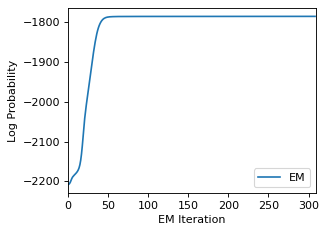

In [28]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### 3b. Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [29]:
T = 1 #inpts.shape[0] # number of trials
K = 3 # number of latent states
C = 2 # number of observation classes or # C represents the binary choice the animal must make
D = inpts.shape[1] # number of GLM inputs (regressors)

# # Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])]

Text(0, 0.5, 'p(state)')

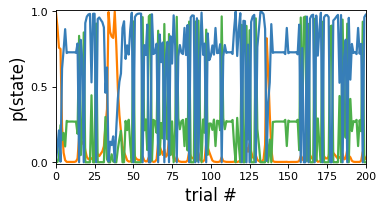

In [30]:
trials_to_plot = (0, 200) # number of trials to plot

cols = ['#ff7f00', '#4daf4a', '#377eb8']
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlim(trials_to_plot) 
plt.xlabel("trial #", fontsize = 15)

plt.ylabel("p(state)", fontsize = 15)

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [31]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

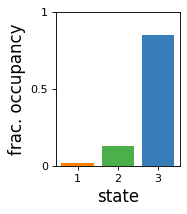

In [32]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

In [100]:
model_gen_weights = new_glmhmm.observations.params
model_gen_weights

array([[[  0.25267932,   0.26483932,   1.43911221,  -0.74794489]],

       [[ 10.18895751, -11.392715  ,  -2.41182912,  -7.04738554]],

       [[-17.85272445,  10.87464218,  -0.46251768,  -0.10808553]]])

In [12]:
filtered_data.loc[:, 'State_Occupancy'] = state_max_posterior # State_Max_Posterior contains the state for each given trial 

#save new csv
#filtered_data.to_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FullMerged_2nBack_100423.csv', index=True)

## Validation - confirming that the number of states chosen is optimal. 

We will be looping through a list of num_states and running the model on each. We will then plot the log likelihoods and see which number of states produces the highest log likelihood. Importantly, we are changing our observation to 'bernoulli', which assumes that the observations are binary. This is because we are modeling the animal's choice data, which is binary.

In [101]:
example_mouse = 'GR'
example_data = data_[(data_['Session ID'].str.contains(example_mouse)) & (data_['Condition'] == '80-20')]
#example_data = data_[(data_['Condition'] == '80-20')]

# Extracting specific columns
example_x = example_data[['1_Port', '2_Port', '1_Reward', '2_Reward']]
example_y = example_data['Reward']
example_trials = len(example_x)
num_sess = len(example_data['Session ID'].unique())
num_trials_per_sess = example_trials


In [102]:
# number of latent states, adds bias 
K = 3
# C represents the binary choice the animal must make 
C = 2 
# number of GLM inputs (regressors) 
D = example_x.shape[1]

num_sess = num_sess # number of example sessions
num_trials_per_sess = example_trials # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, K)) # initialize inpts array
stim_vals = [0, 1]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct formats


In [103]:
# Data inputs 
choices = example_data['Decision'].to_numpy()
choices = choices.reshape(-1, 1)
choices = choices.astype(int)

inpts = example_data[['1_Port', '1_Reward', '2_Port', '2_Reward']].to_numpy()

# Model Inputs
num_states = [1, 2, 3, 4] # number of discrete states
obs_dim =  1 # number of observed dimensions, 1 for just reward, 2 if you had something like reaction time
num_categories = 2 # number of categories for the output
input_dim = inpts.shape[1]

In [104]:
test_glmhmm_list = []
for i in range(len(num_states)):
    
    test_glmhmm = ssm.HMM(num_states[i], obs_dim, input_dim, observations="bernoulli")

    N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
    fit_ll = test_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)
    test_glmhmm_list.append(test_glmhmm)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [105]:
for ii in range(len(test_glmhmm_list)):
    print('Model with ' + str(num_states[ii]) + ' states has a log likelihood of ' + str(test_glmhmm_list[ii].log_likelihood(choices, inputs=inpts)))

Model with 1 states has a log likelihood of -2592.7076259642154
Model with 2 states has a log likelihood of -2052.8354639616023
Model with 3 states has a log likelihood of -2038.1668087577884
Model with 4 states has a log likelihood of -2034.8477543578774


In [106]:
#Convert to bits per state
bits_per_state = []
for ii in range(len(test_glmhmm_list)):
    import math
    bits_per_trial = (-(test_glmhmm_list[ii].log_likelihood(choices, inputs=inpts)-(0.5))/(num_trials_per_sess*np.log(2)))
    bits_per_state.append(bits_per_trial)

([<matplotlib.axis.XTick at 0x20f20746610>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

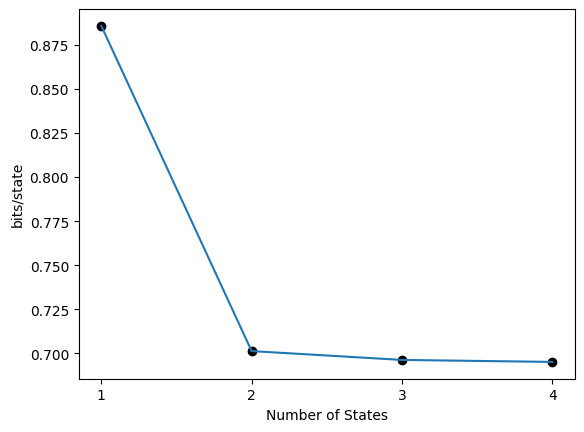

In [107]:
#Plot bits/state
plt.plot(num_states, bits_per_state)
plt.scatter(num_states, bits_per_state, marker='o', color='k')
plt.xlabel('Number of States')
plt.ylabel('bits/state')
plt.xticks(num_states)

### Plotting transition matrix: Here, we will look at the resulting transition matrix. You can select any model output from the list below to plot.

Text(0.5, 1.0, 'Generative transition matrix')

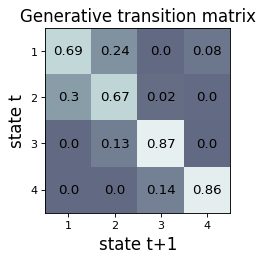

In [109]:
num_states_2plot = 4
gen_weights = test_glmhmm_list[3].observations.params #select correct model whether in list, or just test_glmhmm
gen_trans_mat = test_glmhmm_list[3].transitions.params #select correct model whether in list, or just test_glmhmm


# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states_2plot - 0.5)
plt.xticks(range(0, num_states_2plot), ('1', '2', '3', '4'), fontsize=10)
plt.yticks(range(0, num_states_2plot), ('1', '2', '3', '4'), fontsize=10)
plt.ylim(num_states_2plot - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)